In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
from data_utils import balanced_supersample, balanced_subsample
from sklearn import metrics
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import time
from collections import Counter

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%load_ext memory_profiler
%load_ext line_profiler

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/', sr=SR)
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [6]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False,
                        folds=5
                       )
df.head()

,target,h_target,metadata,fold
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...,4
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,3
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,1
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,4
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...,5


In [7]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,4
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,4
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,4
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,4
4,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,3


In [8]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,58.190871,43.667121,45.746463,42.343447,30.084076,48.247964,42.374778,39.387926,37.159804,49.153997,...,-0.151783,0.248175,14.496725,14.949878,3.585011,29.220897,3.871622,1,36,1
1,57.661319,60.080983,44.186640,48.768903,42.526813,44.876951,34.971382,41.118424,38.246856,45.606720,...,-0.072586,-0.007093,9.667292,28.537172,4.993364,22.758403,4.793919,1,36,1
2,67.650573,73.408686,44.682788,55.750333,39.236220,40.627880,41.786830,46.499063,40.762930,43.984468,...,0.264036,-0.195292,9.728142,24.602081,5.701362,22.282521,4.545848,1,36,1
3,59.714913,55.872608,54.856162,51.512034,49.218383,55.968103,40.890560,44.236659,38.496857,45.733907,...,0.434551,0.186542,13.989773,22.096882,6.127154,19.936294,6.681744,1,36,1
4,65.404965,69.993503,56.847376,54.966564,42.476325,41.917453,43.411913,41.171589,35.436546,40.675832,...,-0.132112,-0.347691,9.866833,15.716688,5.070683,14.813657,3.730182,1,36,1


In [9]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train[['h_target', 'target']]
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test[['h_target', 'target']]

In [10]:
print(train_X.shape)
print(test_X.shape)

(27743, 129)
(6979, 129)


In [11]:
%%file dnnmult.py

import numpy as np
import inspect
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier

class DNN_Multilayer(BaseEstimator, ClassifierMixin):
    def __init__(self, epochs=50, batch_size=35, validation_split=0.05,
                       a_epochs=50, a_batch_size=25,
                       i_epochs=50, i_batch_size=25,
                       verbose=1, proc=None
                ):
        
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")

        for arg, val in values.items():
            setattr(self, arg, val)
            pass
    
    
    def fit(self, X, y):
        
        X = np.array(X)
        y = np.array(y)
        
        if self.proc:
            X = self.proc.fit_transform(X, y[:,1])
        
        dims = X.shape[1]
        t_y = y[:,0]
        a_y = y[:,1][t_y == 0]
        i_y = y[:,1][t_y == 1]
        
        """Top layer of hierarchy"""
        self.clf = KerasClassifier(build_fn=self.deep_net,
                                   feature_count=dims,
                                   epochs=self.epochs, 
                                   batch_size=self.batch_size, 
                                   validation_split=self.validation_split,
                                   verbose=self.verbose
                                  )
        self.clf.fit(X, t_y)
        
        """Animal Layer"""
        self.a_clf = KerasClassifier(build_fn=self.deep_net_a,
                                       feature_count=dims,
                                       epochs=self.a_epochs, 
                                       batch_size=self.a_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        
        self.a_clf.fit(X[t_y == 0], a_y)
        
        """Interacting Materials Layer"""
        self.i_clf = KerasClassifier(build_fn=self.deep_net_i, 
                                       feature_count=dims,
                                       epochs=self.i_epochs, 
                                       batch_size=self.i_batch_size, 
                                       validation_split=self.validation_split,
                                       verbose=self.verbose
                                    )
        self.i_clf.fit(X[t_y == 1], i_y)
        
        return self
        
    def predict(self, X, y=None):
        predictions=[]
        
        if self.proc:
            X = self.proc.transform(np.array(X))
    
        for x in X:
            prob = self.clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze()
            if prob[0] > 0.75:
                pred = self.a_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
            elif prob[1] > 0.75:
                pred = self.i_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
            else:
                a_pred = self.a_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
                i_pred = self.i_clf.predict(x[np.newaxis,:], verbose=0).squeeze()
                
                a_prob = self.a_clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze() * prob[0]
                i_prob = self.i_clf.predict_proba(x[np.newaxis,:], verbose=0).squeeze() * prob[1]
                
                if(np.max(a_prob) > np.max(i_prob)):
                    pred = a_pred
                else:
                    pred = i_pred
                    
            predictions.append(pred)
        
        return predictions
    
    def predict_proba(self, X, y=None):
        
        if self.proc:
            X = self.proc.transform(np.array(X))
        
#         print(self.a_clf.classes_)
#         print(self.i_clf.classes_)
        
        prob = self.clf.predict_proba(X, verbose=0).squeeze()
        prob_a = np.multiply(self.a_clf.predict_proba(X, verbose=0).squeeze().T,prob[:,0]).T
        prob_i = np.multiply(self.i_clf.predict_proba(X, verbose=0).squeeze().T,prob[:,1]).T

        probs = []
        
        for i in range(0, len(prob_a)):
            tmp = [None] * 50
            for counter, j in enumerate(self.a_clf.classes_):
                tmp[j] = prob_a[i][counter]
            for counter, j in enumerate(self.i_clf.classes_):
                tmp[j] = prob_i[i][counter]
            probs.append(tmp)
            
        return np.array(probs)
        
    
    def deep_net(self, feature_count):
        # Create Model
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(feature_count,)))
        model.add(Dropout(0.2))
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(1, activation='softmax'))

        # Compile model
        model.compile(loss='binary_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'])


        return model

    def deep_net_a(self, feature_count):
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(feature_count,)))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(18, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

    def deep_net_i(self, feature_count):
        model = Sequential()
        model.add(Dense(128, activation='relu', input_shape=(feature_count,)))
        model.add(Dense(128, activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dense(int(128/2), activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(32, kernel_initializer='normal', activation='softmax'))

        # Compile model
        model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

        return model

Overwriting dnnmult.py


## Training

In [12]:
from dnnmult import DNN_Multilayer
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA

proc = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50))
])

clf = DNN_Multilayer(proc=proc)

clf.fit(train_X, train_y)

Train on 26355 samples, validate on 1388 samples
Epoch 1/50
26355/26355 [==============================] - 3s 101us/step - loss: 5.4666 - acc: 0.6571 - val_loss: 6.5240 - val_acc: 0.5908
Epoch 2/50
26355/26355 [==============================] - 2s 81us/step - loss: 5.4666 - acc: 0.6571 - val_loss: 6.5240 - val_acc: 0.5908
Epoch 3/50
26355/26355 [==============================] - 2s 85us/step - loss: 5.4666 - acc: 0.6571 - val_loss: 6.5240 - val_acc: 0.5908
Epoch 4/50
26355/26355 [==============================] - 2s 85us/step - loss: 5.4666 - acc: 0.6571 - val_loss: 6.5240 - val_acc: 0.5908
Epoch 5/50
26355/26355 [==============================] - 2s 83us/step - loss: 5.4666 - acc: 0.6571 - val_loss: 6.5240 - val_acc: 0.5908
Epoch 6/50
26355/26355 [==============================] - 2s 83us/step - loss: 5.4666 - acc: 0.6571 - val_loss: 6.5240 - val_acc: 0.5908
Epoch 7/50
26355/26355 [==============================] - 2s 81us/step - loss: 5.4666 - acc: 0.6571 - val_loss: 6.5240 - val_acc

Epoch 10/50
9124/9124 [==============================] - 1s 89us/step - loss: 1.3803 - acc: 0.5489 - val_loss: 2.5003 - val_acc: 0.2266
Epoch 11/50
9124/9124 [==============================] - 1s 102us/step - loss: 1.3150 - acc: 0.5665 - val_loss: 2.3925 - val_acc: 0.2266
Epoch 12/50
9124/9124 [==============================] - 1s 117us/step - loss: 1.2696 - acc: 0.5838 - val_loss: 2.6014 - val_acc: 0.2432
Epoch 13/50
9124/9124 [==============================] - 1s 88us/step - loss: 1.2051 - acc: 0.6085 - val_loss: 2.6602 - val_acc: 0.2225
Epoch 14/50
9124/9124 [==============================] - 1s 112us/step - loss: 1.1591 - acc: 0.6178 - val_loss: 2.6033 - val_acc: 0.2661
Epoch 15/50
9124/9124 [==============================] - 1s 111us/step - loss: 1.1073 - acc: 0.6418 - val_loss: 2.7435 - val_acc: 0.2453
Epoch 16/50
9124/9124 [==============================] - 1s 105us/step - loss: 1.0539 - acc: 0.6555 - val_loss: 2.7686 - val_acc: 0.2287
Epoch 17/50
9124/9124 [====================

17231/17231 [==============================] - 2s 106us/step - loss: 1.3083 - acc: 0.5751 - val_loss: 2.9413 - val_acc: 0.2966
Epoch 20/50
17231/17231 [==============================] - 2s 111us/step - loss: 1.2876 - acc: 0.5800 - val_loss: 2.8773 - val_acc: 0.3153
Epoch 21/50
17231/17231 [==============================] - 2s 101us/step - loss: 1.2584 - acc: 0.5873 - val_loss: 2.9260 - val_acc: 0.3142
Epoch 22/50
17231/17231 [==============================] - 2s 106us/step - loss: 1.2397 - acc: 0.5921 - val_loss: 2.9934 - val_acc: 0.3098
Epoch 23/50
17231/17231 [==============================] - 2s 102us/step - loss: 1.2110 - acc: 0.6023 - val_loss: 3.1077 - val_acc: 0.2734
Epoch 24/50
17231/17231 [==============================] - 2s 103us/step - loss: 1.1792 - acc: 0.6117 - val_loss: 3.0355 - val_acc: 0.3087
Epoch 25/50
17231/17231 [==============================] - 2s 109us/step - loss: 1.1653 - acc: 0.6190 - val_loss: 3.2341 - val_acc: 0.2999
Epoch 26/50
17231/17231 [==============

DNN_Multilayer(a_batch_size=25, a_epochs=50, batch_size=35, epochs=50,
        i_batch_size=25, i_epochs=50,
        proc=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=80, score_func=<function chi2 at 0x7fd2515ea378>)), ('feat_red', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))]),
        validation_split=0.05, verbose=1)

0.2520418398051297
0.1600767336345533
Confusion matrix, without normalization
[[  0   0   0 ...   1   5   2]
 [  0   0   0 ...   0   1   0]
 [  0   0   0 ...   5  12   5]
 ...
 [  0   0   0 ...  45   1   0]
 [  0   0   0 ...   2  75   2]
 [  0   0   0 ...   0   3 107]]


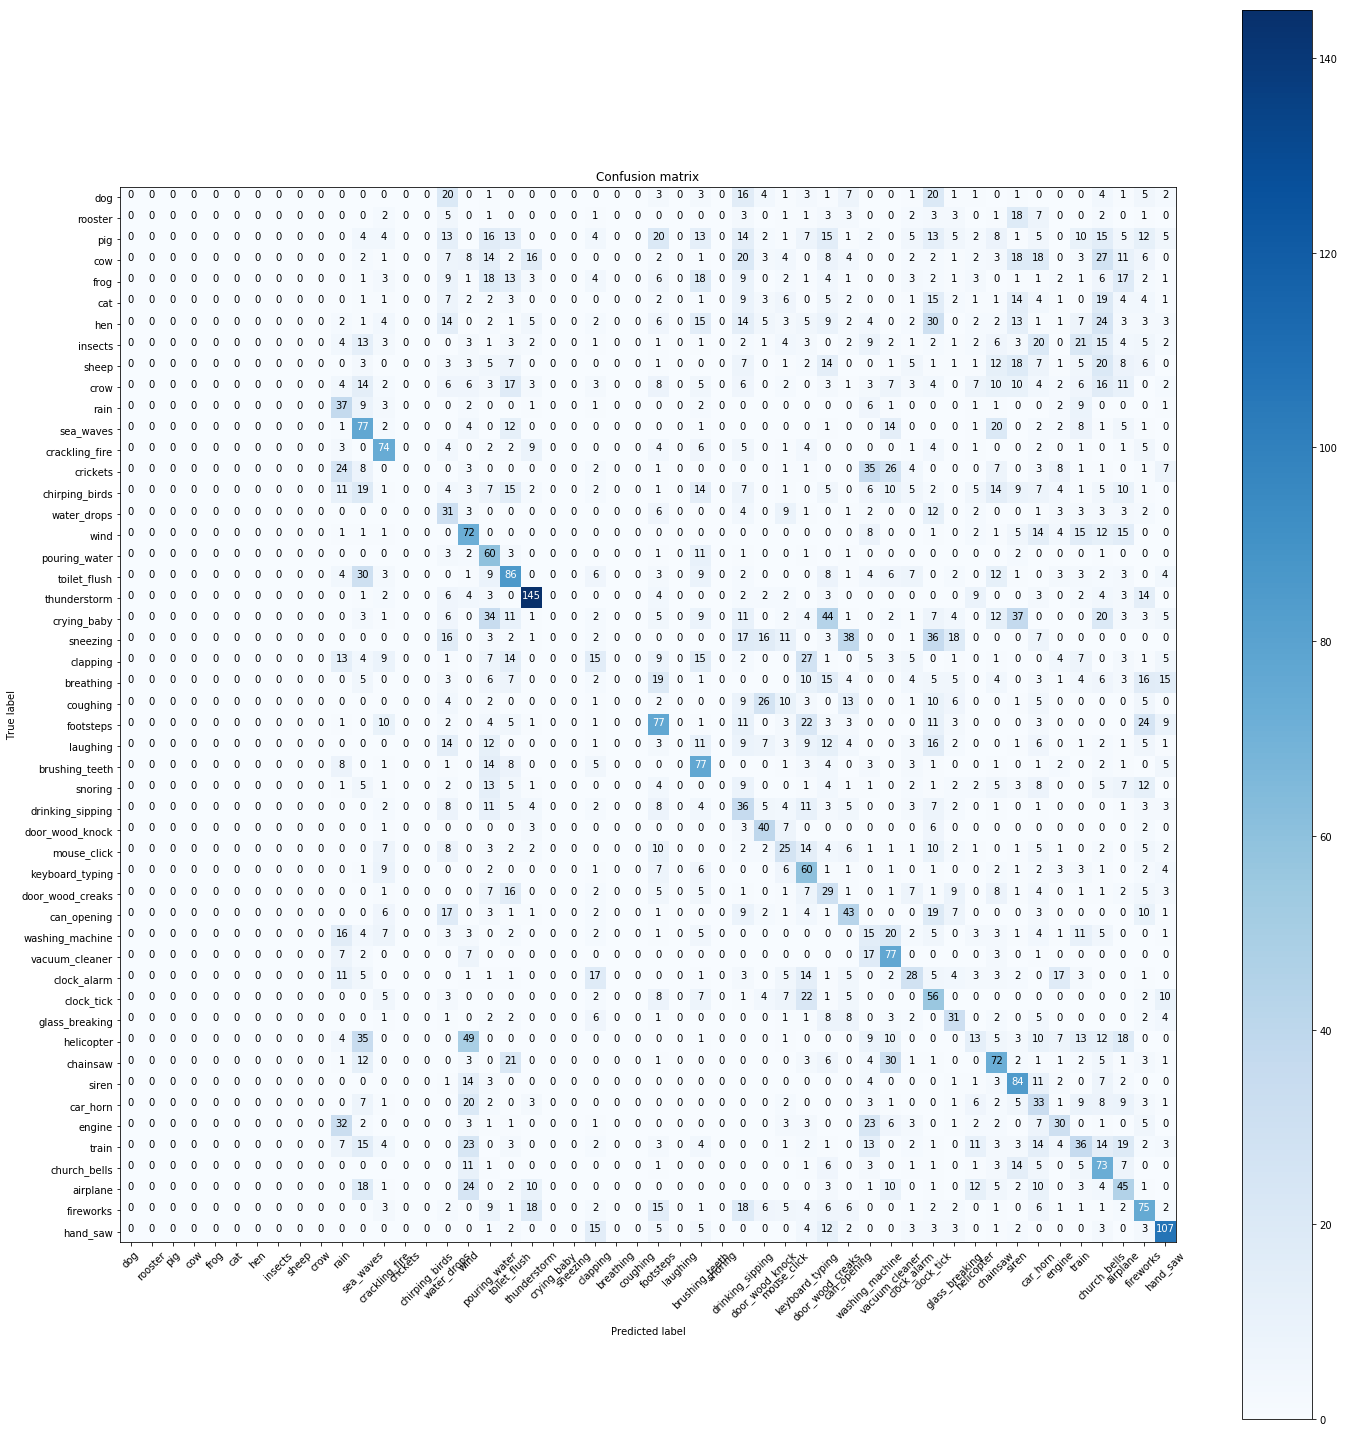

In [13]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_y.values[:,1], pred))
print(metrics.precision_score(test_y.values[:,1], pred, average='macro'))
cm = metrics.confusion_matrix(test_y.values[:,1], pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

## Full Evaluation
We combine the classifiers to determine overall performance

In [14]:
t_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False
                       )
t_df.head()

,target,h_target,metadata
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...


In [15]:
predictions = []
full_targets = []
start_time = time.time()
pred_probs = []

test = df[df.fold == 1]

for data_iloc in range(0,len(test)):
    s_time = time.time()
    x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

    y_file = test.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.0594019889831543
	File Time: 0.04116034507751465
	File Time: 0.03604435920715332
	File Time: 0.03287148475646973
	File Time: 0.030724048614501953
	File Time: 0.029165983200073242
	File Time: 0.028856277465820312
	File Time: 0.02958822250366211
	File Time: 0.029567718505859375
	File Time: 0.028934001922607422
	File Time: 0.02864813804626465
	File Time: 0.029364824295043945
	File Time: 0.02940058708190918
	File Time: 0.02892446517944336
	File Time: 0.029180049896240234
	File Time: 0.011029481887817383
	File Time: 0.02857661247253418
	File Time: 0.02922654151916504
	File Time: 0.028959035873413086
	File Time: 0.02974843978881836
	File Time: 0.030185699462890625
	File Time: 0.02980661392211914
	File Time: 0.03813743591308594
	File Time: 0.041997671127319336
	File Time: 0.035260915756225586
	File Time: 0.03104376792907715
	File Time: 0.029807090759277344
	File Time: 0.029456377029418945
	File Time: 0.029601335525512695
	File Time: 0.04186367988586426
	File Time: 0.023623704910

	File Time: 0.03769874572753906
	File Time: 0.010932683944702148
	File Time: 0.0261688232421875
	File Time: 0.02963566780090332
	File Time: 0.029094934463500977
	File Time: 0.013476133346557617
	File Time: 0.04650735855102539
	File Time: 0.0426483154296875
	File Time: 0.029377222061157227
	File Time: 0.0341184139251709
	File Time: 0.040405988693237305
	File Time: 0.03880953788757324
	File Time: 0.03865385055541992
	File Time: 0.04596114158630371
	File Time: 0.04968452453613281
	File Time: 0.04379606246948242
	File Time: 0.042189836502075195
	File Time: 0.03840374946594238
	File Time: 0.03554248809814453
	File Time: 0.03313755989074707
	File Time: 0.03112173080444336
	File Time: 0.030292272567749023
	File Time: 0.03638339042663574
	File Time: 0.04717659950256348
	File Time: 0.040479183197021484
	File Time: 0.03554248809814453
	File Time: 0.0348515510559082
	File Time: 0.019420146942138672
	File Time: 0.03146243095397949
	File Time: 0.03072524070739746
	File Time: 0.03160452842712402
	Fi

0.3775
0.2534411642708856
Confusion matrix, without normalization
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 ...
 [0 0 0 ... 3 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 8]]


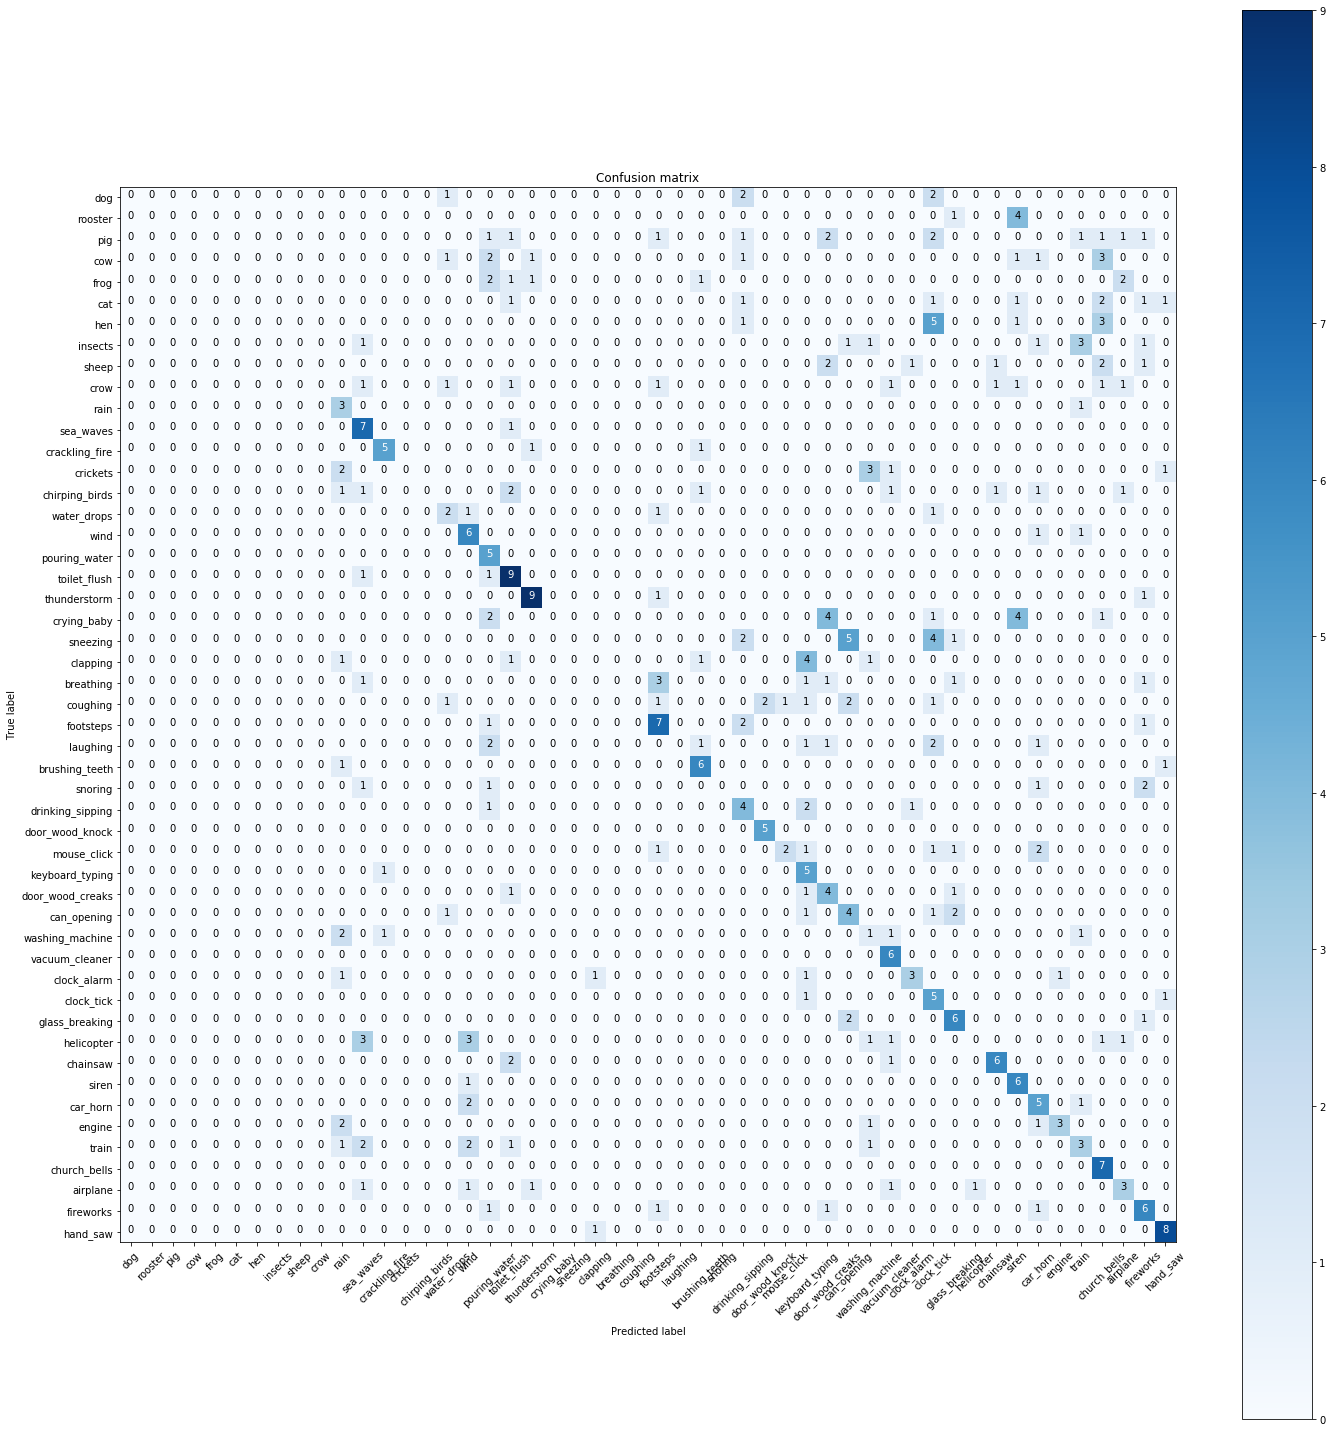

In [16]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [17]:
predictions = []
full_targets = []
start_time = time.time()
pred_probs = []

for data_iloc in range(0,len(df)):
    s_time = time.time()
    x_file = df.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

    y_file = df.iloc[data_iloc].target
    
    pred = clf.predict(x_file)
    b = Counter(np.array(pred))
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(y_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.01842355728149414
	File Time: 0.04515337944030762
	File Time: 0.03866219520568848
	File Time: 0.03522539138793945
	File Time: 0.031580209732055664
	File Time: 0.02994680404663086
	File Time: 0.019680023193359375
	File Time: 0.030419349670410156
	File Time: 0.045995473861694336
	File Time: 0.016800642013549805
	File Time: 0.015700578689575195
	File Time: 0.040897369384765625
	File Time: 0.037702322006225586
	File Time: 0.03493762016296387
	File Time: 0.007624149322509766
	File Time: 0.03318953514099121
	File Time: 0.030765533447265625
	File Time: 0.032158851623535156
	File Time: 0.0306551456451416
	File Time: 0.029208660125732422
	File Time: 0.02942347526550293
	File Time: 0.03688335418701172
	File Time: 0.038251638412475586
	File Time: 0.03851795196533203
	File Time: 0.03424859046936035
	File Time: 0.0320281982421875
	File Time: 0.03159379959106445
	File Time: 0.030633211135864258
	File Time: 0.028436660766601562
	File Time: 0.04261207580566406
	File Time: 0.0423896312713

	File Time: 0.035988569259643555
	File Time: 0.02903127670288086
	File Time: 0.038519859313964844
	File Time: 0.04563760757446289
	File Time: 0.04140067100524902
	File Time: 0.04704403877258301
	File Time: 0.02344679832458496
	File Time: 0.04116964340209961
	File Time: 0.04810953140258789
	File Time: 0.04806995391845703
	File Time: 0.036977529525756836
	File Time: 0.034036874771118164
	File Time: 0.036409616470336914
	File Time: 0.03358626365661621
	File Time: 0.03199601173400879
	File Time: 0.03042006492614746
	File Time: 0.02351546287536621
	File Time: 0.029381275177001953
	File Time: 0.029638290405273438
	File Time: 0.02879643440246582
	File Time: 0.02885746955871582
	File Time: 0.03018331527709961
	File Time: 0.029817819595336914
	File Time: 0.02430129051208496
	File Time: 0.030472278594970703
	File Time: 0.019894838333129883
	File Time: 0.031080007553100586
	File Time: 0.027705907821655273
	File Time: 0.022642135620117188
	File Time: 0.0305325984954834
	File Time: 0.03092265129089

	File Time: 0.023060321807861328
	File Time: 0.0368039608001709
	File Time: 0.033141374588012695
	File Time: 0.030924081802368164
	File Time: 0.028816938400268555
	File Time: 0.02852940559387207
	File Time: 0.028715848922729492
	File Time: 0.029474735260009766
	File Time: 0.028229475021362305
	File Time: 0.028969287872314453
	File Time: 0.029102563858032227
	File Time: 0.04024219512939453
	File Time: 0.04996371269226074
	File Time: 0.051065921783447266
	File Time: 0.04974508285522461
	File Time: 0.044954776763916016
	File Time: 0.05017662048339844
	File Time: 0.048197269439697266
	File Time: 0.04762625694274902
	File Time: 0.04834866523742676
	File Time: 0.0481104850769043
	File Time: 0.04952645301818848
	File Time: 0.04947209358215332
	File Time: 0.02818894386291504
	File Time: 0.047316789627075195
	File Time: 0.04898357391357422
	File Time: 0.048775434494018555
	File Time: 0.04225325584411621
	File Time: 0.017199993133544922
	File Time: 0.044016361236572266
	File Time: 0.021339893341

	File Time: 0.04050731658935547
	File Time: 0.04584550857543945
	File Time: 0.04265403747558594
	File Time: 0.04659318923950195
	File Time: 0.04053497314453125
	File Time: 0.03985738754272461
	File Time: 0.028870820999145508
	File Time: 0.04542374610900879
	File Time: 0.029808759689331055
	File Time: 0.02606987953186035
	File Time: 0.030298233032226562
	File Time: 0.036823272705078125
	File Time: 0.04753899574279785
	File Time: 0.048100948333740234
	File Time: 0.04745340347290039
	File Time: 0.0492093563079834
	File Time: 0.02447795867919922
	File Time: 0.05039095878601074
	File Time: 0.0491945743560791
	File Time: 0.031209230422973633
	File Time: 0.018329858779907227
	File Time: 0.04901003837585449
	File Time: 0.04354095458984375
	File Time: 0.04637551307678223
	File Time: 0.040823936462402344
	File Time: 0.03859257698059082
	File Time: 0.03588700294494629
	File Time: 0.030417680740356445
	File Time: 0.028894424438476562
	File Time: 0.029266357421875
	File Time: 0.04718327522277832
	F

	File Time: 0.04363894462585449
	File Time: 0.04752516746520996
	File Time: 0.04764294624328613
	File Time: 0.03698897361755371
	File Time: 0.0460665225982666
	File Time: 0.00901031494140625
	File Time: 0.04455709457397461
	File Time: 0.04431915283203125
	File Time: 0.04425787925720215
	File Time: 0.04967617988586426
	File Time: 0.047766923904418945
	File Time: 0.04819321632385254
	File Time: 0.046933889389038086
	File Time: 0.048818349838256836
	File Time: 0.046488285064697266
	File Time: 0.023550748825073242
	File Time: 0.03759145736694336
	File Time: 0.04273366928100586
	File Time: 0.041738033294677734
	File Time: 0.032138824462890625
	File Time: 0.049150943756103516
	File Time: 0.05093526840209961
	File Time: 0.026080846786499023
	File Time: 0.04938244819641113
	File Time: 0.02107548713684082
	File Time: 0.043295860290527344
	File Time: 0.049709320068359375
	File Time: 0.04919147491455078
	File Time: 0.04974985122680664
	File Time: 0.04468703269958496
	File Time: 0.0486299991607666

	File Time: 0.04770994186401367
	File Time: 0.03991079330444336
	File Time: 0.03821754455566406
	File Time: 0.036757707595825195
	File Time: 0.041910648345947266
	File Time: 0.048372745513916016
	File Time: 0.04520106315612793
	File Time: 0.022359609603881836
	File Time: 0.03609800338745117
	File Time: 0.03324151039123535
	File Time: 0.03083515167236328
	File Time: 0.04018545150756836
	File Time: 0.04192471504211426
	File Time: 0.04900836944580078
	File Time: 0.04909038543701172
	File Time: 0.04873085021972656
	File Time: 0.04918360710144043
	File Time: 0.0491943359375
	File Time: 0.04299306869506836
	File Time: 0.04805564880371094
	File Time: 0.047521352767944336
	File Time: 0.017752408981323242
	File Time: 0.048697471618652344
	File Time: 0.023815631866455078
	File Time: 0.04967904090881348
	File Time: 0.0476071834564209
	File Time: 0.05074572563171387
	File Time: 0.046387672424316406
	File Time: 0.04876589775085449
	File Time: 0.047415971755981445
	File Time: 0.048986196517944336
	F

	File Time: 0.04431319236755371
	File Time: 0.019265174865722656
	File Time: 0.02718186378479004
	File Time: 0.011242151260375977
	File Time: 0.02667546272277832
	File Time: 0.04714059829711914
	File Time: 0.04180288314819336
	File Time: 0.026662826538085938
	File Time: 0.02469015121459961
	File Time: 0.0494844913482666
	File Time: 0.04663658142089844
	File Time: 0.04834604263305664
	File Time: 0.048554420471191406
	File Time: 0.032198190689086914
	File Time: 0.04886746406555176
	File Time: 0.0204315185546875
	File Time: 0.04798579216003418
	File Time: 0.04987788200378418
	File Time: 0.04942965507507324
	File Time: 0.045114994049072266
	File Time: 0.045076847076416016
	File Time: 0.0387721061706543
	File Time: 0.03521466255187988
	File Time: 0.032494544982910156
	File Time: 0.04419112205505371
	File Time: 0.04540562629699707
	File Time: 0.0452883243560791
	File Time: 0.04759860038757324
	File Time: 0.04937744140625
	File Time: 0.04704713821411133
	File Time: 0.04636383056640625
	File T

	File Time: 0.03731131553649902
	File Time: 0.03477931022644043
	File Time: 0.04271745681762695
	File Time: 0.04788041114807129
	File Time: 0.04110431671142578
	File Time: 0.038713693618774414
	File Time: 0.04641127586364746
	File Time: 0.04732394218444824
	File Time: 0.0432133674621582
	File Time: 0.04063153266906738
	File Time: 0.03767967224121094
	File Time: 0.035436391830444336
	File Time: 0.03433394432067871
	File Time: 0.03249001502990723
	File Time: 0.03144502639770508
	File Time: 0.029998064041137695
	File Time: 0.03582119941711426
	File Time: 0.05052757263183594
	File Time: 0.04412579536437988
	File Time: 0.047397613525390625
	File Time: 0.04884481430053711
	File Time: 0.047426462173461914
	File Time: 0.04023337364196777
	File Time: 0.043627023696899414
	File Time: 0.046939849853515625
	File Time: 0.04444146156311035
	File Time: 0.04569745063781738
	File Time: 0.04894518852233887
	File Time: 0.048111915588378906
	File Time: 0.04822993278503418
	File Time: 0.048707008361816406


0.548
0.3799167027167505
Confusion matrix, without normalization
[[ 0  0  0 ...  0  2  1]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  1  2  1]
 ...
 [ 0  0  0 ... 27  0  0]
 [ 0  0  0 ...  0 36  0]
 [ 0  0  0 ...  0  0 38]]


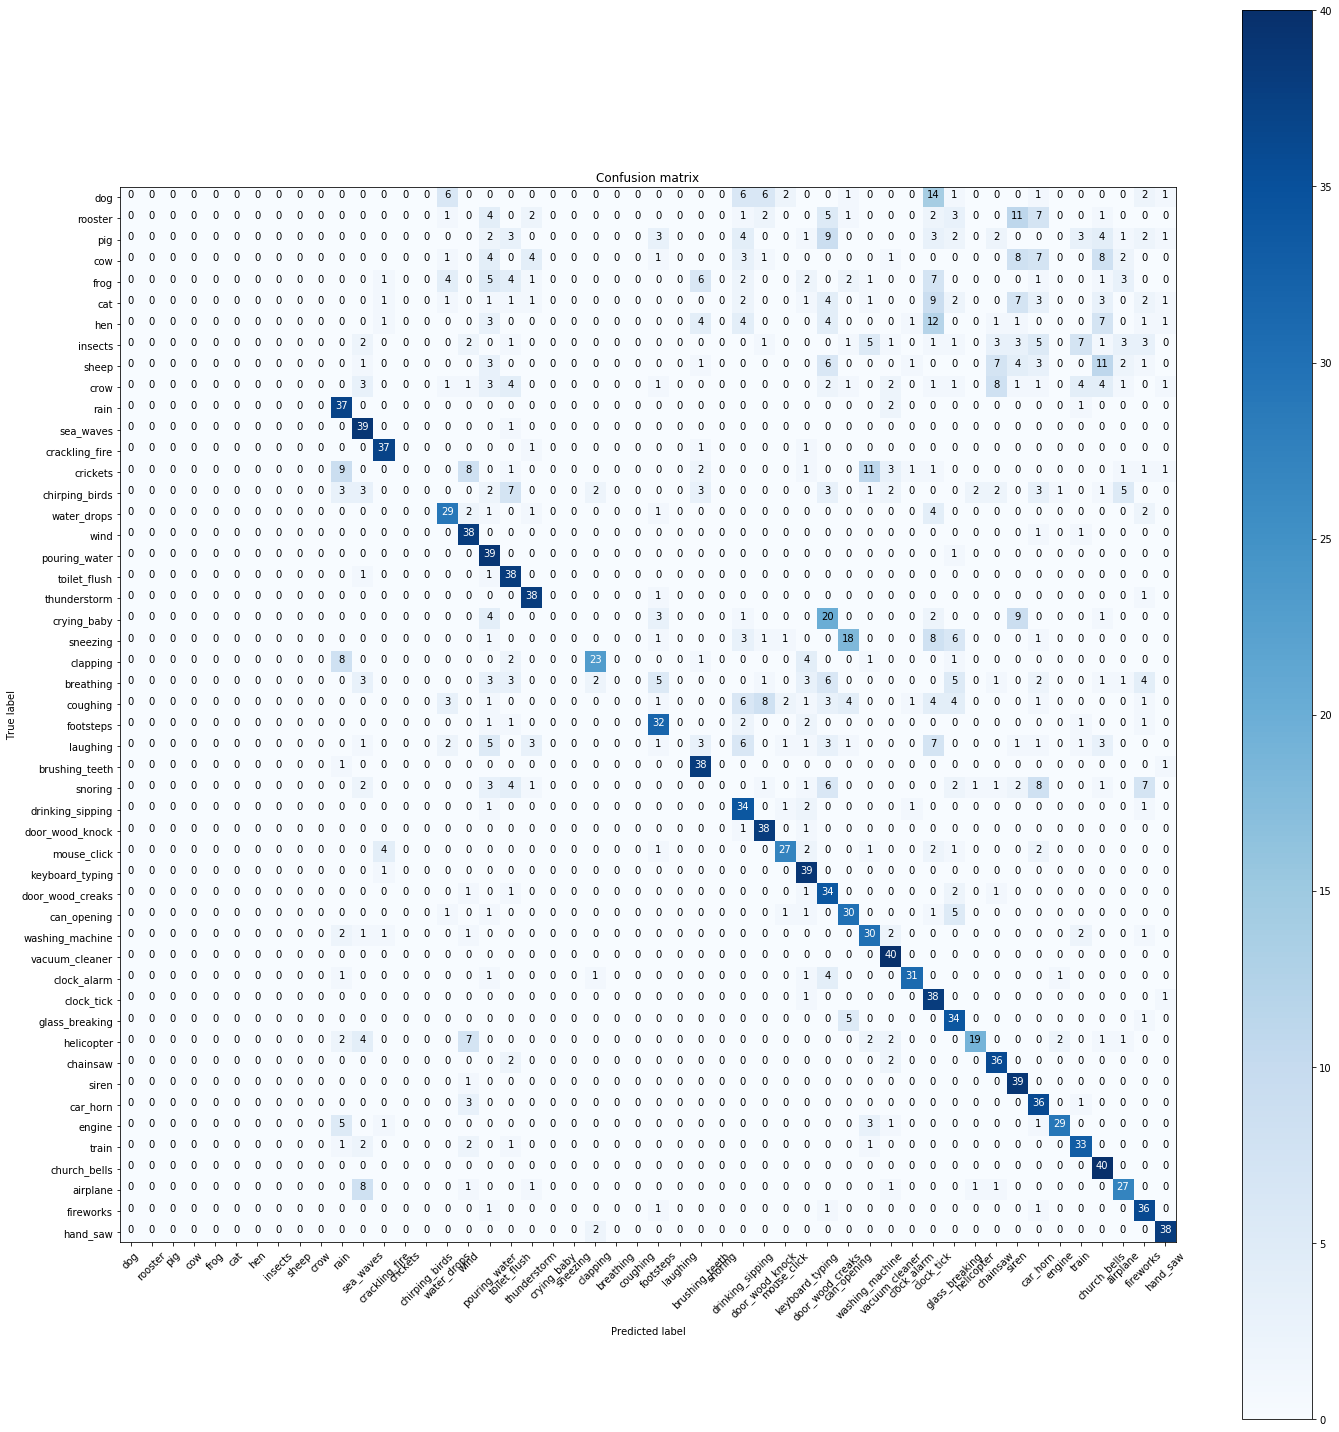

In [18]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [19]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []

    test = df[df.fold == 1]

    for data_iloc in range(0,len(test)):
        s_time = time.time()
        x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

        y_file = test.iloc[data_iloc].target
        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    return predictions

In [20]:
%%time
preds = query_dataset('dog')

CPU times: user 24.7 s, sys: 5.41 s, total: 30.1 s
Wall time: 15.7 s


In [21]:
preds.head()

,ds_id,file,prediction,prob
0,0,1-100032-A-0.wav,"[36, 36, 36, 36, 16, 43, 11, 36, 10, 35, 36, 1...",0.0
1,263,1-53444-A-28.wav,"[33, 34, 37, 42, 42, 42, 42, 29, 34, 43, 43, 4...",0.0
2,273,1-54752-A-18.wav,"[19, 25, 12, 12, 19, 12, 12, 25, 12, 48, 12, 1...",0.0
3,272,1-54747-A-46.wav,"[41, 36, 41, 41, 36, 41, 41, 41, 33, 33, 42, 4...",0.0
4,271,1-54505-A-21.wav,"[17, 17, 17, 17, 17, 17, 17, 17, 27, 27, 32, 2...",0.0


In [22]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [23]:
# Checking index
check_accuracy(preds, 'dog', 10)

dog
['snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']



0.1

In [24]:
accuracies = []
for cls in classes:
    %time preds = query_dataset(cls)
    %time acc = check_accuracy(preds, cls, 10)
    print(cls)
    print(acc)
    print()
    accuracies.append(acc)
    
np.average(accuracies)

CPU times: user 22.7 s, sys: 5.49 s, total: 28.2 s
Wall time: 14.4 s
dog
['snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.04 ms
dog
0.1

CPU times: user 25.4 s, sys: 5.62 s, total: 31 s
Wall time: 16.3 s
rooster
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 12.4 ms
rooster
0.0

CPU times: user 24.5 s, sys: 5.57 s, total: 30.1 s
Wall time: 15.5 s
pig
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 10.8 ms
pig
0.0

CPU times: user 22.1 s, sys: 5.55 s, total: 27.6 s
Wall time: 13.7 s
cow
['dog', 'snoring', 'toilet_flush', 'church_bells', 'sneezing', 'siren', 'train', 'train', 'toilet_flush', 'coughing']

CPU times: u

CPU times: user 25.1 s, sys: 5.3 s, total: 30.4 s
Wall time: 17.9 s
door_wood_knock
['hen', 'pig', 'water_drops', 'coughing', 'wind', 'sheep', 'laughing', 'snoring', 'sea_waves', 'washing_machine']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.88 ms
door_wood_knock
0.0

CPU times: user 24.7 s, sys: 4.87 s, total: 29.5 s
Wall time: 16.9 s
mouse_click
['water_drops', 'crickets', 'snoring', 'crying_baby', 'coughing', 'frog', 'coughing', 'coughing', 'rooster', 'keyboard_typing']

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 14.7 ms
mouse_click
0.0

CPU times: user 25.4 s, sys: 4.71 s, total: 30.1 s
Wall time: 17.5 s
keyboard_typing
['coughing', 'crow', 'coughing', 'can_opening', 'pig', 'mouse_click', 'crying_baby', 'siren', 'chirping_birds', 'chainsaw']

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 8.45 ms
keyboard_typing
0.0

CPU times: user 23.8 s, sys: 4.94 s, total: 28.7 s
Wall time: 16.1 s
door_wood_creaks
['pouring_water', 'chainsaw', 'engine', 's

0.018000000000000002